# Описание проекта
Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

---

# Ознакомление с данными и предобработка
Импортируем необходимые библиотеки и изучим данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_contract = pd.read_csv('contract.csv', parse_dates = ['BeginDate', 'EndDate'],
                         index_col = ['customerID'])
df_internet = pd.read_csv('internet.csv', index_col = ['customerID'])
df_personal = pd.read_csv('personal.csv', index_col = ['customerID'])
df_phone = pd.read_csv('phone.csv', index_col = ['customerID'])

Создадим функцию, которая позволит создать столбец IsGone, в котором будет 1, если пользователь ушёл и 0, если пользователь остался. Приведём столбец EndDate к формату datetime, добавим столбец Duration, в котором обозначим время, которое пользователь провёл с компанией. Если у пользователя в столбце EndDate стоит No, то датой EndDate будем считать 02.02.2020 - то есть дату выгрузки датасета.

In [2]:
def check_if_gone(cell):
    if cell != 'No':
        return 1
    else:
        return 0
    
df_contract['IsGone'] = df_contract['EndDate'].apply(check_if_gone)
df_contract['EndDate'].replace({"No" : "2020-02-01 00:00:00"}, inplace = True)
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format = '%Y-%m-%d %H:%M:%S')
df_contract['Duration'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days
display(df_contract.head())

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsGone,Duration
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


Добавим функцию, которая будет принимать значение в ячейке и заменять: Yes на 1, No на 0. Все остальные значения изменены не будут, то есть NaN'ы сохранятся. Считаю, что от них избавляться ни в коем случае не нужно по крайней мере пока что.

В столбцах, в которых все данные - это Yes/No, заменим значения на 0 и 1. Таким образом, во всех столбцах будут значения типа integer или float.

Объединим все таблицы в одну большую, которая будет содержать всю информацию о пользователях. Мы добавили столбец Duration. Отбросим столбце EndDate, поскольку от него толку в дальнейшем будет мало. Простые модели с datetime сработать не смогут.

В столбце TotalCharges есть несколько не численных значений. Заменим их на NaN'ы. Отбросим те 9 строк, в которых содержатся NaN в столбце TotalCharges. Приведём название столбца gender к Gender (регистр).

В столбцах, в которых есть несколько строчных значений, проведём OHE (one hot encoding). Это позволит перейти от нескольких строчных значений к множеству целочисленных значений.

In [3]:
def yes_for_one(cell):
    if cell == 'Yes':
        return 1
    elif cell == 'No':
        return 0
    else:
        pass


data = df_contract.join(df_internet)
data = data.join(df_personal)
data = data.join(df_phone)

data.drop(['EndDate'], axis = 1, inplace = True)

data['PaperlessBilling'] = data['PaperlessBilling'].apply(yes_for_one)
data['OnlineSecurity'] = data['OnlineSecurity'].apply(yes_for_one)
data['OnlineBackup'] = data['OnlineBackup'].apply(yes_for_one)
data['DeviceProtection'] = data['DeviceProtection'].apply(yes_for_one)
data['TechSupport'] = data['TechSupport'].apply(yes_for_one)
data['StreamingTV'] = data['StreamingTV'].apply(yes_for_one)
data['StreamingMovies'] = data['StreamingMovies'].apply(yes_for_one)

data.rename(columns = {'gender' : 'Gender'}, inplace = True)
data['Gender'].replace({'Male' : 1, 'Female' : 0}, inplace = True)

data['Partner'] = data['Partner'].apply(yes_for_one)
data['Dependents'] = data['Dependents'].apply(yes_for_one)
data['MultipleLines'] = data['MultipleLines'].apply(yes_for_one)

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors = 'coerce')

data.dropna(subset = ['TotalCharges'], inplace = True)
data.reset_index(drop = True)

data_ohe = pd.get_dummies(data, drop_first = True)

display(data_ohe.head())
data_ohe.info()

,BeginDate,PaperlessBilling,MonthlyCharges,TotalCharges,IsGone,Duration,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,SeniorCitizen,Partner,Dependents,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,1,29.85,29.85,0,31,0.0,1.0,0.0,0.0,...,0,1,0,NaN,0,0,0,1,0,0
5575-GNVDE,2017-04-01,0,56.95,1889.50,0,1036,1.0,0.0,1.0,0.0,...,0,0,0,0.0,1,0,0,0,1,0
3668-QPYBK,2019-10-01,1,53.85,108.15,1,61,1.0,1.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,1,0
7795-CFOCW,2016-05-01,0,42.30,1840.75,0,1371,1.0,0.0,1.0,1.0,...,0,0,0,NaN,1,0,0,0,0,0
9237-HQITU,2019-09-01,1,70.70,151.65,1,61,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,1,0,1


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   BeginDate                              7032 non-null   datetime64[ns]
 1   PaperlessBilling                       7032 non-null   int64         
 2   MonthlyCharges                         7032 non-null   float64       
 3   TotalCharges                           7032 non-null   float64       
 4   IsGone                                 7032 non-null   int64         
 5   Duration                               7032 non-null   int64         
 6   OnlineSecurity                         5512 non-null   float64       
 7   OnlineBackup                           5512 non-null   float64       
 8   DeviceProtection                       5512 non-null   float64       
 9   TechSupport                            5512 non-null 

Таким образом, получили общую таблицу с данными по всем пользователям. Столбцов со строками или символами нет. Пропуски есть, но их пока что не удаляем. Это можно будет сделать в любой момент. Перейдём к следующей части - исследовательскому анализу данных.

# Исследовательский анализ данных
Изучим каждый датасет по отдельности. Начнём с contract

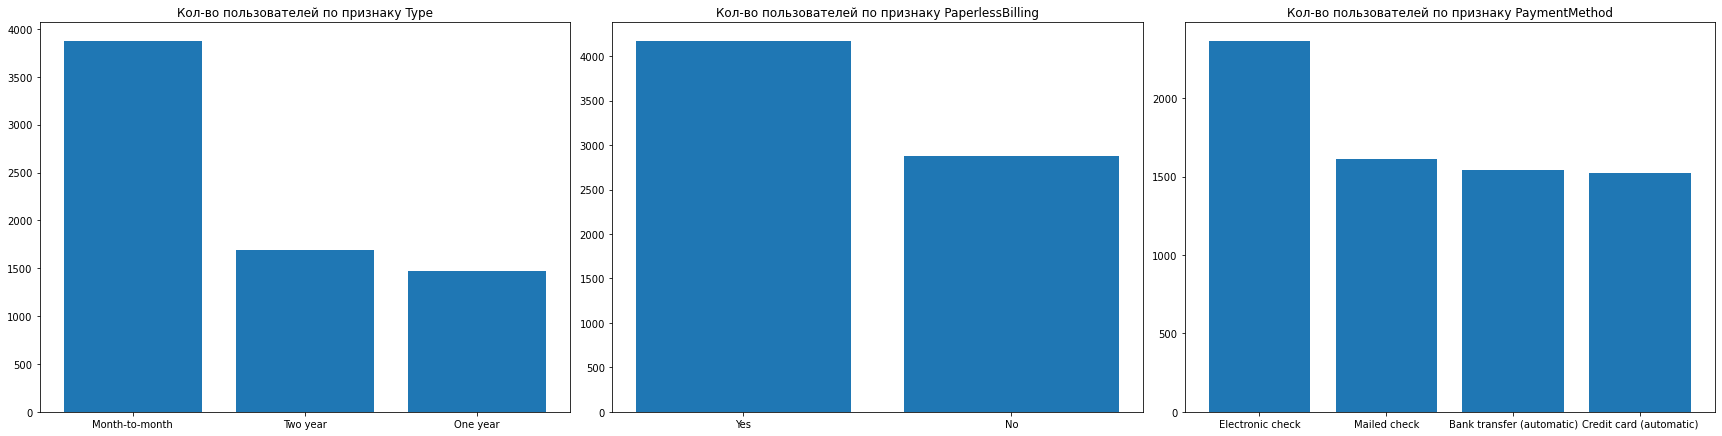

In [4]:
fig_contract, ax_contract = plt.subplots(figsize = (24, 6), nrows = 1, ncols = 3)
plt.tight_layout()
count = 0

for name in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    ax_contract[count].set_title('Кол-во пользователей по признаку ' + name)
    auxillary = df_contract[name].value_counts()
    ax_contract[count].bar(auxillary.index, auxillary.values)
    count += 1

plt.show()

del count, fig_contract, ax_contract

Пока что видно, что большинство пользователей предпочитает оплачивать услуги раз в месяц, а не оформлять оплату сразу за год или два. Большинство предпочитает выставление счёта не на бумажных носителях. По способу оплаты большинство пользователей используют электронный чек, далее идут чек по почте, банковский перевод (автоматизированный) или автоматическое списание с кредитной карты. 

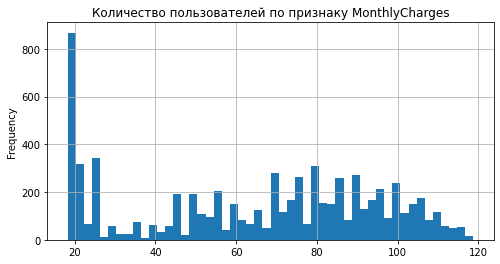

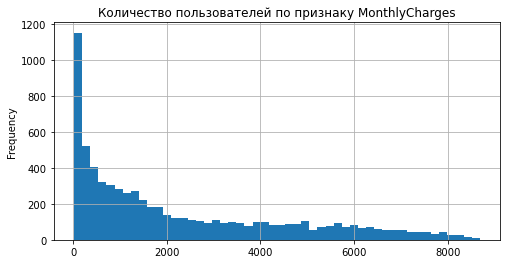

In [5]:
df_contract['MonthlyCharges'].plot(kind = 'hist', bins = 50, grid = True,
                                  title = 'Количество пользователей по признаку MonthlyCharges',
                                  figsize = (8, 4))
plt.show()

pd.to_numeric(df_contract['TotalCharges'], errors = 'coerce').dropna().plot(kind = 'hist', bins = 50, grid = True,
                                  title = 'Количество пользователей по признаку MonthlyCharges',
                                  figsize = (8, 4))
plt.show()

Большинство пользователей платит порядка 10-20 рублей в месяц, но нет какого-то чёткого значения, к которому тяготели бы все пользователи. Кто-то платит больше, кто-то меньше. По признаку TotalCharges видно, что большое количество пользователей заплатили пока что совсем немного.

Перейдём к датасету personal.

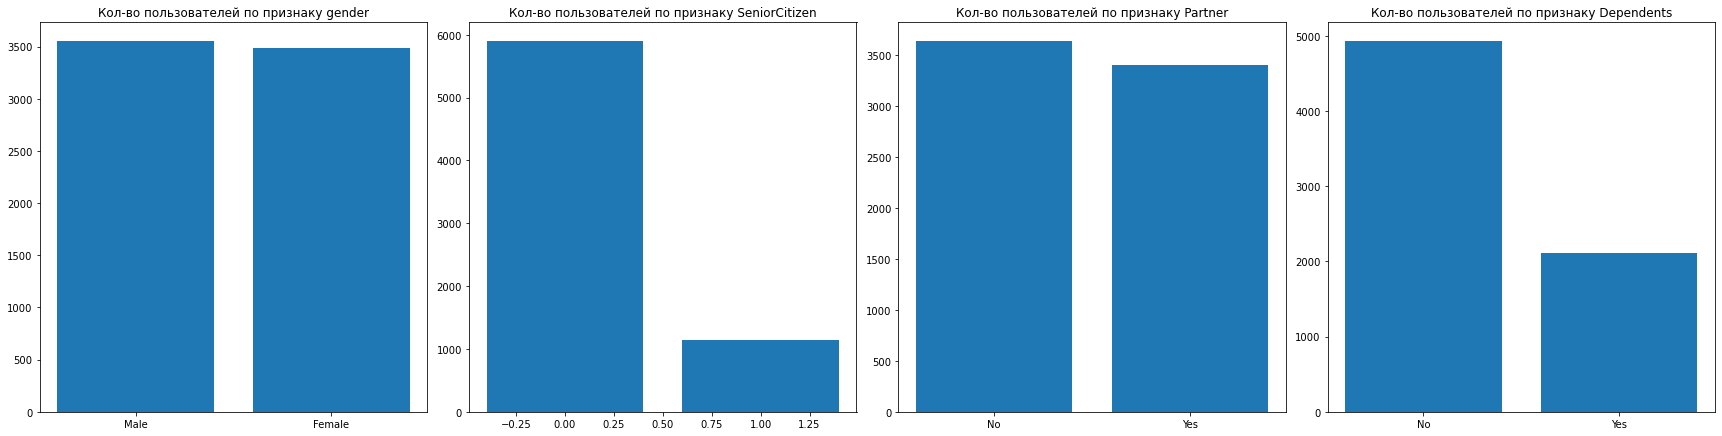

In [6]:
fig_personal, ax_personal = plt.subplots(figsize = (24, 6), nrows = 1, ncols = 4)
plt.tight_layout()
count = 0

for name in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    ax_personal[count].set_title('Кол-во пользователей по признаку ' + name)
    auxillary = df_personal[name].value_counts()
    ax_personal[count].bar(auxillary.index, auxillary.values)
    count += 1
    
plt.show()

del count, fig_personal, ax_personal

По полученным графикам можно сделать следующие выводы:
- Женщин и мужчин примерно поровну
- Пенсионеров гораздо меньше, чем не пенсионеров
- Количество людей в браке и без примерно равны, но несколько больше людей, не состоящих в браке
- Большинсто пользователей не имеют иждивенцев

Перейдём к датасету internet.

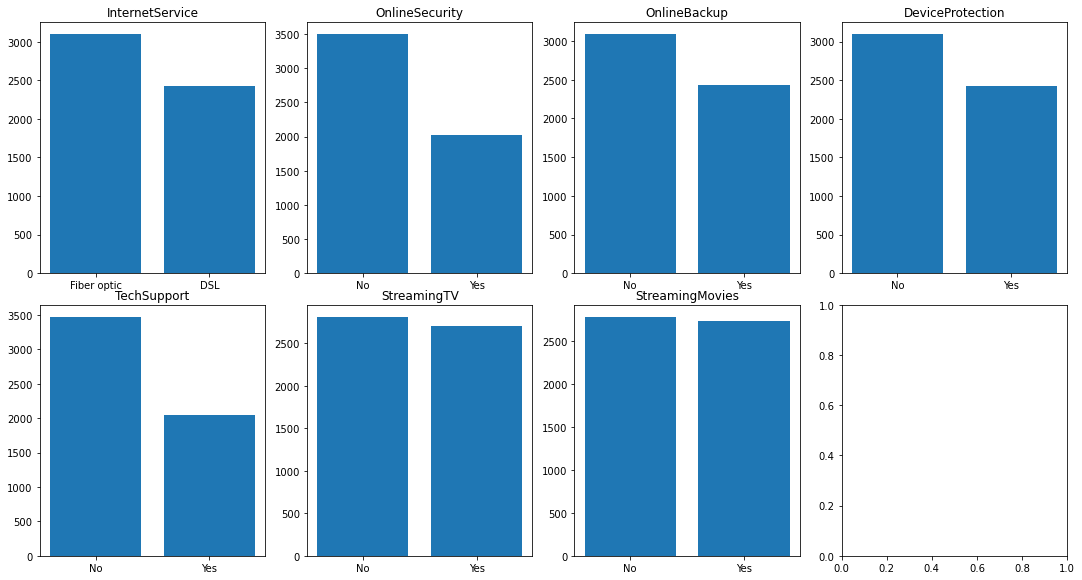

In [7]:
fig_internet, ax_internet = plt.subplots(figsize = (15, 8), nrows = 2, ncols = 4)
plt.tight_layout()
count_i = 0
count_j = 0

for name in df_internet.columns:
    auxillary = df_internet[name].value_counts()
    ax_internet[count_j, count_i].set_title(name)
    ax_internet[count_j, count_i].bar(auxillary.index, auxillary.values)
    count_i += 1
    if count_i > 3:
        count_i = 0
        count_j += 1
plt.show()

Можно сделать следующие выводы:
- Оптоволокном пользуется большее количество пользователей, чем DSL
- Болшинство пользователей не используют услуги блокировки небезопасных сайтов
- По использованию облачного хранилища пользователей примерно поровну. Чуть больше всё же им не ползуется
- Примерно та же история с использованием антивируса
- Большинство пользователей не используют техподдержку
- Примерно поровну количество пользователей по использованиюю стримингово TV и по использованию стриминга фильмов.

Рассмотрим датасет phone:

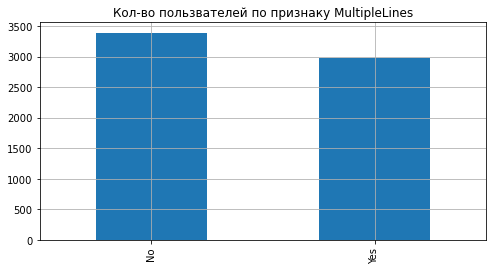

In [8]:
df_phone['MultipleLines'].value_counts().plot(kind = 'bar', grid = True, figsize = (8 , 4),
                                          title = 'Кол-во пользвателей по признаку MultipleLines')
plt.show()

Что интересно, есть много пользователей, использующих многоканальную связь. Здесь результаты примерно поровну, хотя тех, кто ей не пользуется, всё же больше.

# Итог
Бегло проведён исследовательский анализ данных. Получили более-менее общую картину по пользователям.

Далее представлен план решения задачи:
1. Определить наиболее важные признаки для построения модели
2. Попытаться провести объединение данных в одну таблицу, которая бы содержала все важные признаки
3. Разделим данные на обучающую, валидационную и тестовую выборку
4. Будем использовать catboost. Проведём обучение и кросс-валидацию.
5. Получим предсказания и изучим конечные метрики.

# Обучение моделей
Ключевая метрика в данном задании - auc-roc. Будем исследовать следующие модели:
1. CatBoost
2. RandomForestClassifier
3. LogisticRegression

Почему стоит избавиться от пропусков.

Абсолютно корректно заменить все пропуски не получится. Часть из заменённых пропусков будут только усиливать осреднённую или медианную составляющую всей выборки. Если же заменять на наиболее похожую строку, то может возникнуть проблема с тем, что многие строки похожи друг на друга. А об истинном распределении данных что-то сказать всё равно будет трудно. Скорее всего, я неправ, но я убеждён, что замена пропусков в не физическом эксперименте - дело несколько шарлатанское.

In [9]:
data_ohe.fillna(0, inplace = True)
data_ohe.info()
table_corr = data_ohe.corr()
display(table_corr[table_corr > 0.75])

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   BeginDate                              7032 non-null   datetime64[ns]
 1   PaperlessBilling                       7032 non-null   int64         
 2   MonthlyCharges                         7032 non-null   float64       
 3   TotalCharges                           7032 non-null   float64       
 4   IsGone                                 7032 non-null   int64         
 5   Duration                               7032 non-null   int64         
 6   OnlineSecurity                         7032 non-null   float64       
 7   OnlineBackup                           7032 non-null   float64       
 8   DeviceProtection                       7032 non-null   float64       
 9   TechSupport                            7032 non-null 

,PaperlessBilling,MonthlyCharges,TotalCharges,IsGone,Duration,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,SeniorCitizen,Partner,Dependents,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic
PaperlessBilling,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.787195
TotalCharges,NaN,NaN,1.000000,NaN,0.825811,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsGone,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,NaN,NaN,0.825811,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineBackup,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeviceProtection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TechSupport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StreamingTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Есть несколько столбцов со значением степени корреляции больше 0,75. Уберём их.
<a class="anchor" id="0-bullet">

0:	learn: 0.6931464	total: 143ms	remaining: 42.8s
100:	learn: 0.6930745	total: 864ms	remaining: 1.7s
200:	learn: 0.6930024	total: 1.49s	remaining: 734ms
299:	learn: 0.6929309	total: 2.15s	remaining: 0us

accuracy на тестовой выборке: 0.7908629441624365

roc-auc для модели catboost на тестовой выборке: 0.8286550877895158 



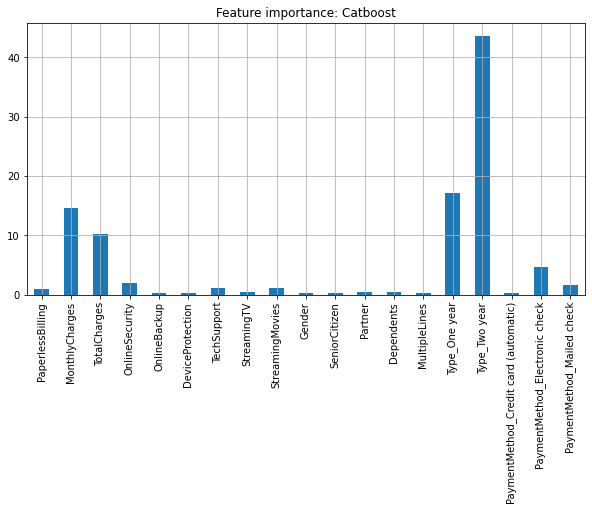

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

features_to_drop = ['IsGone', 'BeginDate', 'InternetService_Fiber optic', 'Duration']
features = data_ohe.drop(features_to_drop, axis = 1)
target = data_ohe['IsGone'].copy()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.14,
                                                    random_state = 42)

model = CatBoostClassifier(loss_function = "Logloss", iterations = 300, random_seed = 42,
                           learning_rate = 0.000001,
                           depth = 8)

model.fit(X_train, y_train, verbose = 100)
preds = model.predict(X_test)
print('\naccuracy на тестовой выборке:', accuracy_score(y_test, preds))

probabilities_valid = model.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(y_test, probabilities_one_valid)

print('\nroc-auc для модели catboost на тестовой выборке:', auc_roc, '\n')

catboost_importance = model.get_feature_importance()
catboost_df = pd.Series(index = features.columns, data = catboost_importance)
catboost_df.plot(kind = 'bar', grid = True, figsize = (10, 5),
                title = 'Feature importance: Catboost')
plt.show()

### Вывод по catboost
С feature importance получилось так, что важны только несколько столбцов: Type_Two year, Type_One year, MonthlyCharges и TotalCharges. Это хорошо видно на графике. Остальные признаки не оказывают значимого влияния.

In [11]:
from sklearn.model_selection import cross_val_score
basic_catboost_scores = cross_val_score(model, X_train, y_train, cv = 4, verbose = False)

0:	learn: 0.6931464	total: 5.93ms	remaining: 1.77s
1:	learn: 0.6931457	total: 12.6ms	remaining: 1.87s
2:	learn: 0.6931449	total: 19.2ms	remaining: 1.9s
3:	learn: 0.6931442	total: 25.4ms	remaining: 1.88s
4:	learn: 0.6931435	total: 31.6ms	remaining: 1.86s
5:	learn: 0.6931427	total: 37.7ms	remaining: 1.85s
6:	learn: 0.6931421	total: 44ms	remaining: 1.84s
7:	learn: 0.6931413	total: 50.3ms	remaining: 1.83s
8:	learn: 0.6931406	total: 55.4ms	remaining: 1.79s
9:	learn: 0.6931398	total: 61.4ms	remaining: 1.78s
10:	learn: 0.6931391	total: 67.6ms	remaining: 1.77s
11:	learn: 0.6931384	total: 74.1ms	remaining: 1.78s
12:	learn: 0.6931376	total: 80.7ms	remaining: 1.78s
13:	learn: 0.6931369	total: 84.8ms	remaining: 1.73s
14:	learn: 0.6931361	total: 91.1ms	remaining: 1.73s
15:	learn: 0.6931353	total: 97.5ms	remaining: 1.73s
16:	learn: 0.6931346	total: 104ms	remaining: 1.73s
17:	learn: 0.6931339	total: 110ms	remaining: 1.73s
18:	learn: 0.6931331	total: 116ms	remaining: 1.72s
19:	learn: 0.6931324	total: 

186:	learn: 0.6930097	total: 1.26s	remaining: 763ms
187:	learn: 0.6930089	total: 1.27s	remaining: 756ms
188:	learn: 0.6930082	total: 1.27s	remaining: 749ms
189:	learn: 0.6930075	total: 1.28s	remaining: 742ms
190:	learn: 0.6930067	total: 1.29s	remaining: 735ms
191:	learn: 0.6930060	total: 1.29s	remaining: 728ms
192:	learn: 0.6930052	total: 1.3s	remaining: 721ms
193:	learn: 0.6930044	total: 1.3s	remaining: 714ms
194:	learn: 0.6930038	total: 1.31s	remaining: 706ms
195:	learn: 0.6930032	total: 1.32s	remaining: 699ms
196:	learn: 0.6930025	total: 1.32s	remaining: 692ms
197:	learn: 0.6930018	total: 1.33s	remaining: 685ms
198:	learn: 0.6930010	total: 1.33s	remaining: 678ms
199:	learn: 0.6930003	total: 1.34s	remaining: 670ms
200:	learn: 0.6929995	total: 1.35s	remaining: 663ms
201:	learn: 0.6929989	total: 1.35s	remaining: 656ms
202:	learn: 0.6929981	total: 1.36s	remaining: 649ms
203:	learn: 0.6929973	total: 1.36s	remaining: 642ms
204:	learn: 0.6929966	total: 1.37s	remaining: 635ms
205:	learn: 0.

56:	learn: 0.6931055	total: 371ms	remaining: 1.58s
57:	learn: 0.6931047	total: 377ms	remaining: 1.57s
58:	learn: 0.6931040	total: 383ms	remaining: 1.56s
59:	learn: 0.6931033	total: 386ms	remaining: 1.54s
60:	learn: 0.6931026	total: 392ms	remaining: 1.53s
61:	learn: 0.6931018	total: 397ms	remaining: 1.52s
62:	learn: 0.6931011	total: 403ms	remaining: 1.52s
63:	learn: 0.6931004	total: 409ms	remaining: 1.51s
64:	learn: 0.6930997	total: 414ms	remaining: 1.49s
65:	learn: 0.6930989	total: 419ms	remaining: 1.49s
66:	learn: 0.6930982	total: 431ms	remaining: 1.5s
67:	learn: 0.6930975	total: 438ms	remaining: 1.49s
68:	learn: 0.6930968	total: 445ms	remaining: 1.49s
69:	learn: 0.6930960	total: 451ms	remaining: 1.48s
70:	learn: 0.6930953	total: 458ms	remaining: 1.48s
71:	learn: 0.6930946	total: 464ms	remaining: 1.47s
72:	learn: 0.6930939	total: 469ms	remaining: 1.46s
73:	learn: 0.6930931	total: 476ms	remaining: 1.45s
74:	learn: 0.6930924	total: 482ms	remaining: 1.45s
75:	learn: 0.6930917	total: 488m

226:	learn: 0.6929833	total: 1.44s	remaining: 462ms
227:	learn: 0.6929826	total: 1.44s	remaining: 456ms
228:	learn: 0.6929819	total: 1.45s	remaining: 449ms
229:	learn: 0.6929812	total: 1.45s	remaining: 442ms
230:	learn: 0.6929805	total: 1.46s	remaining: 436ms
231:	learn: 0.6929798	total: 1.47s	remaining: 429ms
232:	learn: 0.6929791	total: 1.47s	remaining: 423ms
233:	learn: 0.6929783	total: 1.48s	remaining: 417ms
234:	learn: 0.6929777	total: 1.48s	remaining: 410ms
235:	learn: 0.6929770	total: 1.49s	remaining: 403ms
236:	learn: 0.6929763	total: 1.49s	remaining: 397ms
237:	learn: 0.6929756	total: 1.5s	remaining: 392ms
238:	learn: 0.6929748	total: 1.51s	remaining: 386ms
239:	learn: 0.6929741	total: 1.52s	remaining: 379ms
240:	learn: 0.6929733	total: 1.52s	remaining: 373ms
241:	learn: 0.6929727	total: 1.53s	remaining: 367ms
242:	learn: 0.6929720	total: 1.53s	remaining: 360ms
243:	learn: 0.6929712	total: 1.54s	remaining: 353ms
244:	learn: 0.6929705	total: 1.54s	remaining: 347ms
245:	learn: 0

96:	learn: 0.6930761	total: 594ms	remaining: 1.24s
97:	learn: 0.6930753	total: 600ms	remaining: 1.24s
98:	learn: 0.6930746	total: 607ms	remaining: 1.23s
99:	learn: 0.6930738	total: 614ms	remaining: 1.23s
100:	learn: 0.6930731	total: 621ms	remaining: 1.22s
101:	learn: 0.6930723	total: 627ms	remaining: 1.22s
102:	learn: 0.6930716	total: 641ms	remaining: 1.23s
103:	learn: 0.6930709	total: 650ms	remaining: 1.22s
104:	learn: 0.6930702	total: 662ms	remaining: 1.23s
105:	learn: 0.6930694	total: 673ms	remaining: 1.23s
106:	learn: 0.6930689	total: 686ms	remaining: 1.24s
107:	learn: 0.6930682	total: 694ms	remaining: 1.23s
108:	learn: 0.6930676	total: 701ms	remaining: 1.23s
109:	learn: 0.6930668	total: 707ms	remaining: 1.22s
110:	learn: 0.6930662	total: 712ms	remaining: 1.21s
111:	learn: 0.6930655	total: 717ms	remaining: 1.2s
112:	learn: 0.6930647	total: 724ms	remaining: 1.2s
113:	learn: 0.6930639	total: 743ms	remaining: 1.21s
114:	learn: 0.6930632	total: 749ms	remaining: 1.21s
115:	learn: 0.6930

269:	learn: 0.6929513	total: 1.66s	remaining: 184ms
270:	learn: 0.6929506	total: 1.66s	remaining: 178ms
271:	learn: 0.6929499	total: 1.67s	remaining: 172ms
272:	learn: 0.6929491	total: 1.67s	remaining: 166ms
273:	learn: 0.6929484	total: 1.68s	remaining: 160ms
274:	learn: 0.6929477	total: 1.69s	remaining: 153ms
275:	learn: 0.6929470	total: 1.69s	remaining: 147ms
276:	learn: 0.6929464	total: 1.7s	remaining: 141ms
277:	learn: 0.6929457	total: 1.7s	remaining: 135ms
278:	learn: 0.6929449	total: 1.71s	remaining: 129ms
279:	learn: 0.6929442	total: 1.71s	remaining: 122ms
280:	learn: 0.6929434	total: 1.72s	remaining: 116ms
281:	learn: 0.6929427	total: 1.73s	remaining: 110ms
282:	learn: 0.6929421	total: 1.73s	remaining: 104ms
283:	learn: 0.6929413	total: 1.74s	remaining: 97.9ms
284:	learn: 0.6929406	total: 1.74s	remaining: 91.7ms
285:	learn: 0.6929398	total: 1.75s	remaining: 85.6ms
286:	learn: 0.6929391	total: 1.75s	remaining: 79.5ms
287:	learn: 0.6929385	total: 1.76s	remaining: 73.4ms
288:	lear

139:	learn: 0.6930525	total: 842ms	remaining: 962ms
140:	learn: 0.6930519	total: 845ms	remaining: 953ms
141:	learn: 0.6930512	total: 852ms	remaining: 948ms
142:	learn: 0.6930505	total: 858ms	remaining: 942ms
143:	learn: 0.6930498	total: 864ms	remaining: 936ms
144:	learn: 0.6930491	total: 870ms	remaining: 930ms
145:	learn: 0.6930486	total: 875ms	remaining: 923ms
146:	learn: 0.6930479	total: 879ms	remaining: 914ms
147:	learn: 0.6930473	total: 884ms	remaining: 908ms
148:	learn: 0.6930466	total: 890ms	remaining: 902ms
149:	learn: 0.6930459	total: 896ms	remaining: 896ms
150:	learn: 0.6930452	total: 900ms	remaining: 888ms
151:	learn: 0.6930445	total: 906ms	remaining: 883ms
152:	learn: 0.6930438	total: 913ms	remaining: 877ms
153:	learn: 0.6930434	total: 916ms	remaining: 868ms
154:	learn: 0.6930427	total: 922ms	remaining: 863ms
155:	learn: 0.6930420	total: 929ms	remaining: 857ms
156:	learn: 0.6930413	total: 936ms	remaining: 852ms
157:	learn: 0.6930407	total: 939ms	remaining: 844ms
158:	learn: 

In [12]:
print(f'Среднее значение accuracy при кросс-валидации для catboost \
= {basic_catboost_scores.mean()}')

Среднее значение accuracy при кросс-валидации для catboost = 0.7989114877144328


In [13]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 300, max_depth = 13, random_state = 42)
rfc.fit(X_train, y_train)

scores_rfc = cross_val_score(rfc, X_train, y_train, cv = 8)
print(f'Среднее значение accuracy при кросс-валидации для RandomForestClassifier \
= {scores_rfc.mean()}')

probabilities_valid_rfc = rfc.predict_proba(X_test)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

auc_roc_rfc = roc_auc_score(y_test, probabilities_one_valid_rfc)

print(f'\nauc-roc для модели RandomForestClassifier на тестовой выборке = {auc_roc_rfc}')

Среднее значение accuracy при кросс-валидации для RandomForestClassifier = 0.7970927940712709

auc-roc для модели RandomForestClassifier на тестовой выборке = 0.8299400693047407


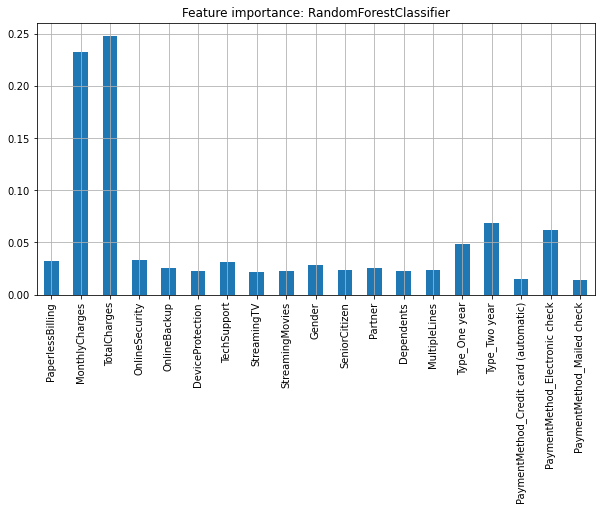

In [14]:
importance_rfc = rfc.feature_importances_

rfc_df = pd.Series(index = features.columns, data = importance_rfc)
rfc_df.plot(kind = 'bar', grid = True, figsize = (10, 5),
                title = 'Feature importance: RandomForestClassifier')
plt.show()

### Вывод по RandomForestClassifier
Значимыми оказались только столбцы: MonthlyCharges, TotalCharges. Гораздо меньшую, но не самую маленькую значимость имеют столбцы: Type_One year, Type_Two year, PaymentMethod_Electronic check. Остальные столбцы имеют небольшое значение.

In [15]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
lr.fit(X_train, y_train)

scores_lr = cross_val_score(lr, X_train, y_train, cv = 8)
print(f'Среднее значение accuracy при кросс-валидации для LogisticRegression \
= {scores_lr.mean()}')

probabilities_valid_lr = lr.predict_proba(X_test)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

auc_roc_lr = roc_auc_score(y_test, probabilities_one_valid_lr)

print(f'\nauc-roc для модели LogisticRegression на тестовой выборке = {auc_roc_lr}')

Среднее значение accuracy при кросс-валидации для LogisticRegression = 0.7454962945443078

auc-roc для модели LogisticRegression на тестовой выборке = 0.8231149215845297


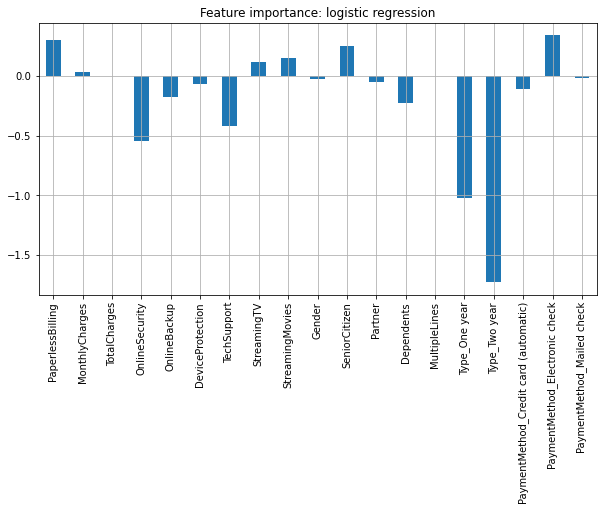

In [16]:
importance_lr = lr.coef_[0]
lr_df = pd.Series(index = features.columns, data = importance_lr)
lr_df.plot(kind = 'bar', grid = True, figsize = (10, 5),
          title = 'Feature importance: logistic regression')
plt.show()

### Вывод по feature importance: logistic regression
Наиболее значимые столбцы: Type_One year, Type_Two year. Остальные столбцы не столь важны.

# Общий вывод
В итоге лучшей моделью оказалась RandomForestClassifier, у которой самое высокое значение как для accuracy, так и для roc-auc. Наибольшее значение roc-auc = 0.83 на тестовой выборке.